# Teleportación Cuántica

## Creación del circuito y simulacion en condiciones ideales

Este circuito esta diseñado para pasar una informacion quantica concreta de un lado a otro. Por ejemplo madar un qubit |ψ⟩=α|0⟩+β|1⟩, lo que significaria pasar información sobrea α y β.

Como existe el teorema de que no se puede copiarla información exacta de un estado cuantico desconocido, llamado teorema de la no clonación, no podemos simplemente generar una copia de un qubit y mandarla, solo de un estado clásico y no de superposiciones.

Entonces usaremos dos bits y un par entrelazado de qubits para pasar el estado, lo que llamamos teleportación cuantica. Recive este nombre ya que al final qubit inicial ,llamemosle q0 pasará a no tener el estado |ψ⟩ y a su vez tendra o estado |0⟩ o |1⟩ y el qubit final o al que queremos pasarle el estado acabará valiendo |ψ⟩

### Quiskit

En este apartado se expone como implementar un circuito de teleportacion cuantica en qiskit y a partir de el poder enviar un qubit de q0 a q2 ayudandonos de q1.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex

En esta primera parte creamos los diferentes qubits y bits que utilizaremos a lo largo del circuito y daremos nombre al circuito que vamos a crear

In [2]:
qr = QuantumRegister(3, name="q")    
crz = ClassicalRegister(1, name="crz") 
crx = ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

Esta funcion sera usada par crear un par de bell el cual se utilizara para entrelazar dos qubits 

In [3]:
def create_bell_pair(qc, a, b):
    qc.h(a) # Aplicamos una Hadamard a 'a'
    qc.cx(a,b) # Aplicamos una cnot a 'b' 
               # usando 'a' como qubit de control

Y entrelazamos q1 y q2 con la funcion anterior.

In [4]:
create_bell_pair(teleportation_circuit, 1, 2)

teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Esta funcion sirve para definir lo que el qubit q0 hará para prepararse para el envio realizando una especie de par de bell invertido con q2

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

Se miden los resultados de q0 y q1 y se envian para que q2 los trate para poder luego hacer los cambios necesarios para obtener el qubit inicial en q0.

In [7]:
def measure_and_send(qc, a, b):
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

El qubit q2 despues de obtener la medicion de los dos qubits realiza una serie de puertas segun los valores de los bits que recive. En concreto si el segundo bit es un uno realiza una puerta X y si el primer bit recivido es un uno realiza una puerta Z sobre q2 

In [9]:
def bob_gates(qc, qubit, crz, crx):
    qc.x(qubit).c_if(crx, 1)
    qc.z(qubit).c_if(crz, 1)

In [10]:
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                  ║  ║       │   ┌──┴──┐
crz: 1/═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                  0  ║    ┌──┴──┐└─────┘
crx: 1/══════════════════════════════╩════╡ = 1 ╞═══════
                                     0    └─────┘

Creamos un qubit aleatorio que llamaremos psy y mostramos su esfera de bloch para poder comprobar si el circuito realiza bien la teleportacion cuantica

<IPython.core.display.Math object>

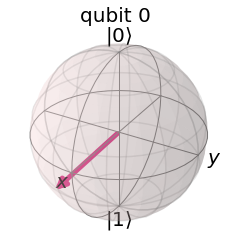

In [11]:
psi = random_state(1)

array_to_latex(psi, pretext="|\\psi\\rangle =")

plot_bloch_multivector(psi)

Creamos una puerta init que realiza la inicializacion de qbit a el valor aleatorio que hemos creado anteriormente

In [12]:
init_gate = Initialize(psi)
init_gate.label = "init"

Creamos el nuevo circuito añadiendo la puerta de inicialización

In [13]:
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)


# Inicializamos el qubit q0
qc.append(init_gate, [0])
qc.barrier()

# Entrelazamos q1 y q2
create_bell_pair(qc, 1, 2)
qc.barrier()

# Enviamos q1 al emisor y q2 al receptor de el estado inicial aleatorio
alice_gates(qc, 0, 1)


# El emisor envia sus bits clasicos obtenidos de q0 y q1 al receptor
measure_and_send(qc, 0, 1)

# Se decodifics el mensaje en el receptor
bob_gates(qc, 2, crz, crx)

qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ 
                                             ║  ║    │   ┌──┴──┐
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞
                                             0  ║ ┌──┴──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

Simulamos el circuito y comprovamos que el valor de q2 es identico al valor inicila aleatorio de q0 y que q1 vuelcan en |0> o |1>. 
Hemos comprovado que el circuito a transportado el qubit psi de q0 a q2

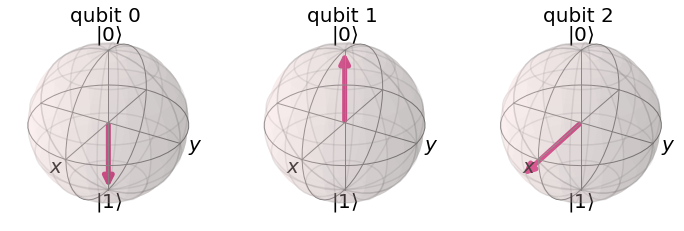

In [16]:
sv_sim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
out_vector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(out_vector)

Creamos la puerta inversa de la inicializadora

In [17]:
inverse_init_gate = init_gate.gates_to_uncompute()

In [18]:
qc.append(inverse_init_gate, [2])
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║    │   ┌──┴──┐»
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞»
                                             0  ║ ┌──┴──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
«                       
«  q_0: ────────────────
«                       
«  q_1: ────────────────
«       ┌──────────────┐
«  q_2: ┤ disentangler ├
«       └──────────────┘
«crz: 1/════════════════
«                       
«crx: 1/════════════════
«

In [19]:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─┬─┘  └─┬─┘ »
                                             ║  ║    │   ┌──┴──┐»
crz: 1/══════════════════════════════════════╩══╬════╪═══╡ = 1 ╞»
                                             0  ║ ┌──┴──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
 c0: 1/═════════════════════════════════════════════════════════»
                                                                »
«                          
«  q_0: ───────────────────
«                          
«  q_1: ───────────────────
«       ┌──────────────┐┌─┐
«  q_2: ┤ disentangler ├┤M├
«       └──────────────┘└╥┘
«crz: 1/═════════════════╬═
«                        ║ 
«crx: 1/═════════════════╬═
«                        ║ 
« c0: 1/═════════════════╩═
«                        0

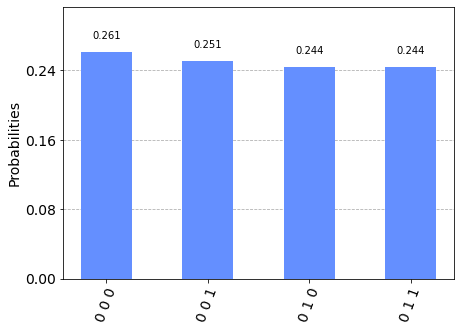

In [20]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

## Simulacion en condiciones no ideales

Como en computadores cuanticos reales solo se puede medir al final del cicuito entonces tenemos que cambiar ligeramente el circuito para que las puertas que se realizaran a q2 no dependan de las mediciones en bits clasicos de q0 y q1 sino de q0 y q1 como tales. Para eso la puerta X dependera de q1 en vez de su conversion en bit y la Z dependera del qubit q0 como tal tambien.

In [21]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [22]:
qc = QuantumCircuit(3,1)

qc.append(init_gate, [0])
qc.barrier()

create_bell_pair(qc, 1, 2)
qc.barrier()

alice_gates(qc, 0, 1)
qc.barrier()


# En vez de enviar sus dos bits clasicos, el 
# receptor utiliza los qubits q0 y q1 directamente.
new_bob_gates(qc, 0, 1, 2)


qc.append(inverse_init_gate, [2])

#vemos el estado de q2 que es el que nos interesa
qc.measure(2,0)

qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░───────■────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │                    
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░───■───┼────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░─┤ X ├─■─┤ disentangler ├┤M├
              ░      └───┘ ░            ░ └───┘   └──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

### Ejecucion con modelos de ruido

Utilizamos es mismo circuito que vamos utilizar para backends reales para que los resultados tengan una mayor realicion entre ellos y puedan ser comentadas sus similitudes.

In [23]:
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.compiler import transpile, assemble, schedule
IBMQ.save_account('your account', overwrite=True)
provider = IBMQ.load_account()


Número de ocurrencias: {'0 0 0': 233, '0 0 1': 252, '0 1 0': 241, '0 1 1': 250, '1 0 0': 12, '1 0 1': 19, '1 1 0': 11, '1 1 1': 6}


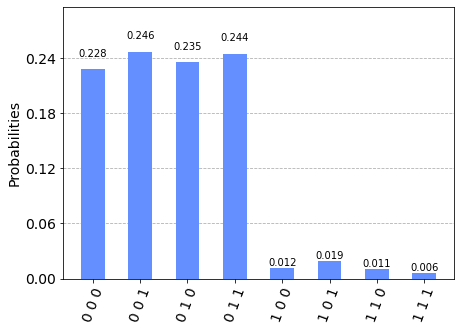

In [24]:
# Construir un modelo de ruido a partir de las características de un backend real
backend = provider.get_backend('ibmq_belem')
noise_model = NoiseModel.from_backend(backend)

# Obtener el mapa de interconexión de los qubits
coupling_map = backend.configuration().coupling_map

# Obtener las características de las puertas básicas
basis_gates = noise_model.basis_gates

######################
# Crear circuito    #
#####################

# Perform a noise simulation
result = execute(t_qc, Aer.get_backend('qasm_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()

######################
# Mostrar resultados #
######################

counts = result.get_counts(t_qc)
print("\nNúmero de ocurrencias:",counts)
plot_histogram(counts)

### Ejecucion en backends reales

Mandamos a ejecutar el nuevo circuito a un ordenador cuantico real y comprabamos los resultados

In [82]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [39]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends (filters=lambda b: b.configuration().n_qubits >= 3 and not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(t_qc)
job = backend.run(qobj)
job_monitor(job)

Job Status: job has successfully run


{'0': 926, '1': 98}


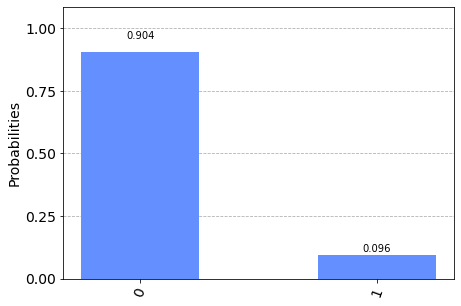

In [84]:
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [25]:
print(f"El error experimental es de: 
      {(exp_counts['1']/sum(exp_counts.values())*100):.3f}%")

El error experimental es de : 9.6%


Vemos que aunque el error no es nulo la tasa de fallos del experimento en menor del 10% que aunq para ordenadores que deberian trabajar con miles de operaciones aun es mucho es bastante impresionante.

### Conclusiones

Como ya vimos en la practica anterior los resultados no son siempre los esperados debido a la existencia de ruido por lo que no siempre funcionara el circuito aunque como vemos en el ultimo apartado de una ejecucion en backend real esta tasa de fallo es muy pequeña.

En cuanto a las diferencias entre la simulacion con ruido y la ejecucion en un ordenador cuantico podemos observar que en el backend real existe una probabilidad mas grande de fallo ya que la suma de las probabilidades de los estados fallidos es 0.052 en la simulación y en el backend real es de 0.096 , que es casi el doble del medido en la simulación, aunque esto se puede deber solo al azar.